# Overriding coverage calculations

When setting parameter values in the model based on spending, fundamentally the operation being carried out is a mapping from spending to parameter value. However, Atomica divides this into three steps to cater for the most common types of programs encountered:

- First, the spending ($\$$) is converted to a capacity
- Then, the capacity is converted to a fractional coverage
- Finally, the fractional coverage is converted to a parameter value

This could be thought of as akin to $P = h(g(f(\$)))$ where $f$, $g$, and $h$ are the `get_capacity()`, `get_coverage()` and `get_outcome()` functions, respectively. 

![default workflow](default_workflow.svg)

However, in some cases it may be desirable to use different functions to calculate the parameter value. In particular, two common use cases would be

- Requiring a custom cost-coverage function, to effectively replace $g(capacity)$ in the example above with $g(\$)$. In Atomica, the standard cost-coverage function uses capacity as an intermediate step, and divides the capacity by the number of people in the program's target compartments in order to calculate the fractional coverage. If a program is targeted at anything other than people/compartments, such as a clinic program that targets clinics, then it may be simpler to define a direct cost-coverage function based on an offline calculation rather than trying to introduce the necessary denominator as a model compartment
- Requiring a nonlinear relationship between coverage and program outcome

These can be catered for in several different ways

## Add a new population type

**Input files**

- [Framework](override_framework_2.xlsx)
- [Databook](override_databook_2.xlsx)
- [Progbook](override_progbook_2.xlsx)

Suppose we have an SIR model and want to add a treatment rate that depends on a program targeted at clinics rather than at individuals. In that case, the denominator for the coverage would be the clinics themselves rather than the people attending the clinic. We could add a new population type in the framework to capture the clinics, and then target programs at this population:

**Population types**

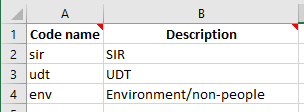

**Compartments**

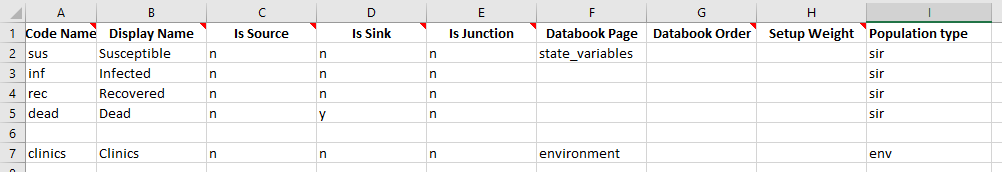

**Parameters**

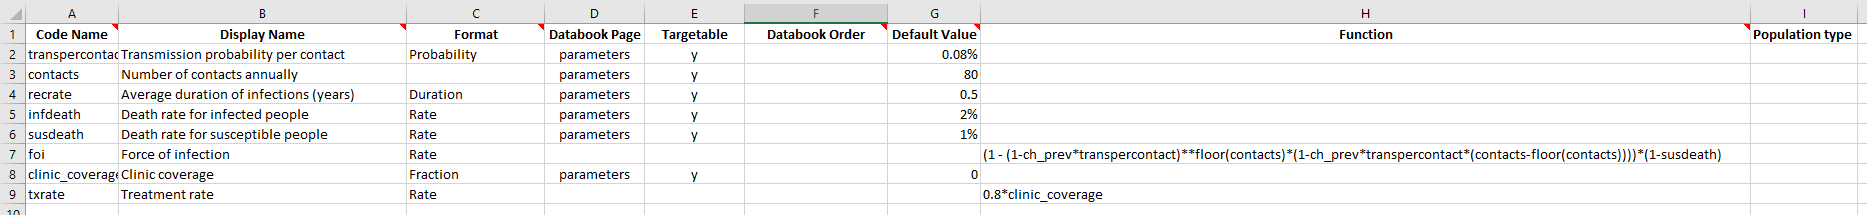

**Transitions**

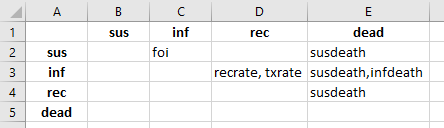


**Databook population types**

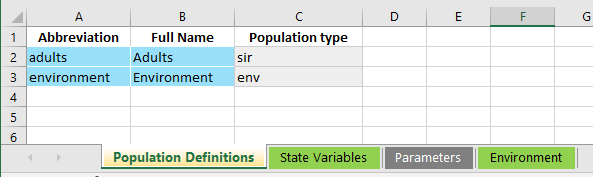

**Databook new variable**

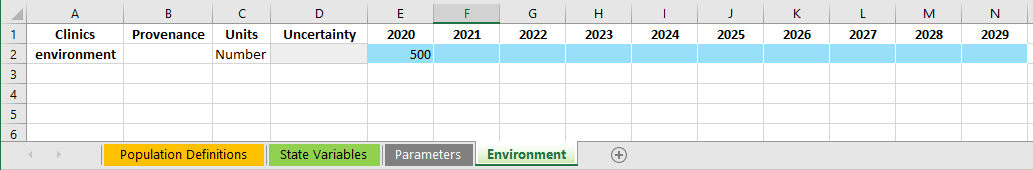

Notice how the databook compartment value is where the number of clinics is specified. Since no parameters drive transitions from this compartment, this fixed value will simply be used at all times. In this simple example, we have a constant number of clinics, so this approach is straightforward. However, if the number of clinics needs to change over time, it would be necessary to introduce transitions, sources, and sinks in order to model this change. Specifying the number of clinics at other times would need to be done indirectly by modifying the transitions instead of directly setting the compartment value. For that use case, the population type approach would probably _not_ be suitable, and instead directly overwriting the functions as described later on in this document would be preferable. 

**Program targeting**

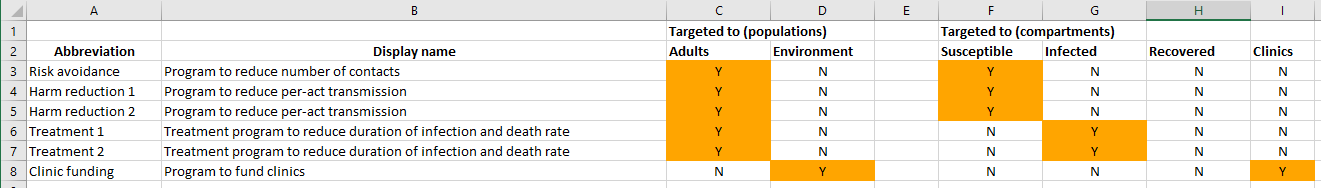

**Spending data**

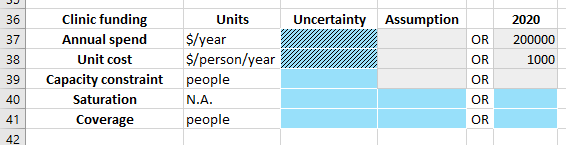

**Program effect**

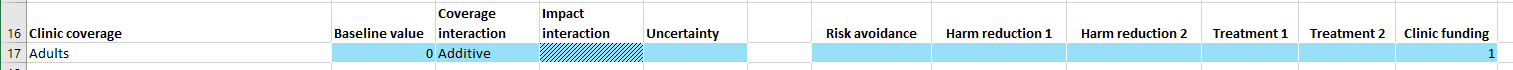

With the program values entered above, the program capacity is $200000/1000=200$ clinics per year (notice that this is implemented as a continuous program), and we have 500 clinics, leading to a fractional coverage of 40%. The program outcome is 0.8 and therefore the final parameter value should be $0.4*0.8=0.32$. 

In [ ]:
import atomica as at
import sciris as sc
import numpy as np

P = at.Project(framework='override_framework_2.xlsx', databook='override_databook_2.xlsx', do_run=False)
P.load_progbook('override_progbook_2.xlsx');
res = P.run_sim(progset=0, progset_instructions=at.ProgramInstructions(start_year=2020))

res.get_variable('clinic_coverage')[0].plot()
res.get_variable('txrate')[0].plot()

## Overwriting coverage

**Input files**

- [Framework](override_framework_1.xlsx)
- [Databook](override_databook_1.xlsx)
- [Progbook](override_progbook_1.xlsx)

Instead of introducing a new population type, we can instead overwrite the coverage functions to return the desired parameter value. In the framework, the parameters and transitions are kept the same as in the example above. However, we no longer need to add a compartment for the clinics. 

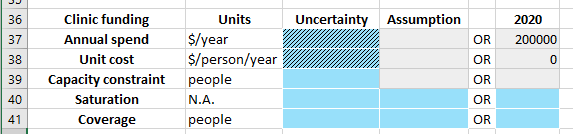

In the program book, the program still needs to be defined, but the program targeting and unit cost entered in the program book won't be used. These may still need to be filled out with arbitrary values (e.g., targeting every compartment) to ensure the programs are loaded correctly. The program spending should still be entered.

To run the model, first load all of the inputs:

In [ ]:
import atomica as at
P = at.Project(framework='override_framework_1.xlsx', databook='override_databook_1.xlsx', do_run=False)
P.load_progbook('override_progbook_1.xlsx');

The desired workflow is shown schematically below:

![Override coverage](new_1_workflow.svg)

Since the coverage calculation is performed in Atomica in two parts, first mapping spending to capacity, and then capacity to coverage, it is necessary to overwrite both functions. To simplify implementation, we will make it so that

- `get_capacity()` returns the desired _fractional coverage_ value
- `get_coverage()` does nothing but directly return its input

This will allow the implementation of spending-to-coverage to be done within a single function. These functions are implemented below:

In [ ]:
def arbitrary_cost_cov_fcn(self, tvec, spending, dt):
    """
    Arbitrary coverage function
    
    :param prog: The program instance (essentially `self` if it was 
                 defined as a method normally) - this argument will 
                 be automatically supplied when the code is called, 
                 but is probably not necessary to use for anything
                 in this use case
    :param tvec: A scalar, list, or array of times
    :param spending: A vector of spending values (in units 
                     of '$/year'), the same size as ``tvec``
    :param dt: The time step size (required because the number covered
               at each time step potentially depends on the spending 
               per-timestep)
    :return: Array the same size as ``tvec``, with fractional timestep
             coverage (should be between 0 and 1)
    """

    tvec = sc.promotetoarray(tvec)
    spending = sc.promotetoarray(spending)

    n_clinics = 500
    cost_per_clinic = 2000
    frac_coverage = np.minimum(n_clinics,np.floor(spending/cost_per_clinic))/n_clinics
    return frac_coverage

def null_get_prop_covered(self, tvec, capacity, eligible):
    """
    Our new arbitrary cost-coverage function overwrites prog.get_capacity 
    to return the fractional coverage directly which is stored in the 
    capacity as a bit of a hack (since capacity is normally in units 
    of people or people/year). Therefore, to return the proportion 
    covered, we just return the capacity (as an array).
    """
    return sc.promotetoarray(capacity)

Notice how previously, the number of clinics was entered in the databook, and the cost-per-clinic was entered as the program's unit cost. Now, both of these values are hard-coded into the cost-coverage function. This provides two distinct advantages

- The number of clinics (or any other analogous quantity) can arbitrarily vary over time
- An arbitrary nonlinear relationship between cost and coverage can be implemented, since the only place the unit cost appears is within this arbitrary function (it is not needed externally)

In this example, the rounding in the calculation for `frac_coverage` enforces that clinics must each be fully funded i.e., only an integer number of clinics can be funded. This type of constraint or implementation detail would be difficult (or impossible) to implement as a standard program. To differentiate this example from the previous one, the unit cost has been doubled, so we would expect that the coverage and final parameter value would be half of the previous example.

Having defined these functions, we need to overwrite the corresponding methods for the program. However, we only want to overwrite the methods for the 'Clinic funding' program while leaving all other programs unchanged. To do this, we will use the `types` module in Python as follow:

In [ ]:
import types

# Get the program
progname = 'Clinic funding'
prog = P.progsets[0].programs[progname]

# Overwrite its methods
prog.get_capacity = types.MethodType(arbitrary_cost_cov_fcn, prog)  # override get_capacity - nb. Cannot just do `prog.get_capacity = arbitrary_cost_cov_fcn`
prog.get_prop_covered = types.MethodType(null_get_prop_covered, prog) # Also override get_coverage

Note that this will need to be performed for every progset in use - if the progbook is loaded again into a new `ProgramSet` instance, the methods will need to be overwritten again. Finally, we can go ahead and run the model:

In [ ]:
res = P.run_sim(progset=0, progset_instructions=at.ProgramInstructions(start_year=2020))
res.get_variable('clinic_coverage')[0].plot()
res.get_variable('txrate')[0].plot()

In this case, we have also gone one step further and overwritten a parameter corresponding to program coverage. That is, we defined a parameter in the framework for 'Clinic coverage' and set the program outcome to have a baseline value of 0 and a fully-funded value of 1. Therefore, the mapping from coverage to outcome is actually implemented in the framework. In the previous example, this facilitated having a continuous program overwrite a transition (that would normally only be impacted by a one-off program - this is important because it affects whether or not a timestep correction factor is included in the computation). However, more generally, this means that you can implement an arbitrary (including nonlinear) function linking coverage to the final parameter value driving transitions in the model. This is of course independent of whether or not the program's coverage has been overwritten - this architecture can be used by any program. 